# **Previsão de uma Série Temporal**
## CTA - Ridership - Daily Boarding Totals

O dataset CTA – Ridership – Daily Boarding Totals contém registros diários do número de embarques no sistema de transporte público da Chicago Transit Authority (CTA) desde 2001, abrangendo diferentes modais, como ônibus (bus) e trens (rail).

In [ ]:
import pandas as pd
from pathlib import Path


Conjunto de dados: [CTA – Ridership – Daily Boarding Totals](https://data.cityofchicago.org/api/views/6iiy-9s97/rows.csv?accessType=DOWNLOAD)

In [ ]:
path = Path("/content/CTA_-_Ridership_-_Daily_Boarding_Totals.csv")
df= pd.read_csv(path,parse_dates=["service_date"])


Inspeção inicial dos dados:

In [ ]:
df.head()

,service_date,day_type,bus,rail_boardings,total_rides
0,2010-02-01,W,1091041,648428,1739469
1,2006-07-15,A,603018,412144,1015162
2,2017-08-26,A,487453,446049,933502
3,2007-12-25,U,249699,111582,361281
4,2005-07-08,W,950222,591325,1541547


Pré-processamento de dados:

In [ ]:
df.columns =["date", "day_type", "bus","rail", "total"] # encurtar nomes
df= df.sort_values("date").set_index("date") # ordeamento das linhas pela data
df= df.drop("total", axis=1) # total não é necessário, somente ônibus + trem
df= df.drop_duplicates() # remove meses duplicados (2011-10 e 2014-07)

In [ ]:
df.head()

,day_type,bus,rail
date,,,
2001-01-01,U,297192,126455
2001-01-02,W,780827,501952
2001-01-03,W,824923,536432
2001-01-04,W,870021,550011
2001-01-05,W,890426,557917


A coluna day_type é interpretada da seguinte forma:


*   W para dias úteis (Weekdays)
*   A para sábados (Saturdays)
*   U para domingos ou feriados (Sundays or holidays)



Plot do número de embarques em ônibus e trens ao longo dos meses de março, abril e maio de 2019.

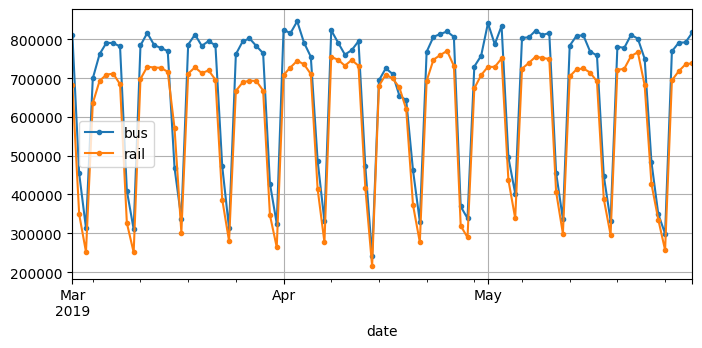

In [ ]:
import matplotlib.pyplot as plt
df["2019-03":"2019-05"].plot(grid=True,marker=".",figsize=(8, 3.5))
plt.show()

### Diferenciação sazonal (seasonal differencing) e previsão ingênua semanal

A diferenciação sazonal de ordem 7 é utilizada para analisar a sazonalidade semanal e avaliar uma previsão ingênua baseada na repetição do padrão semanal.

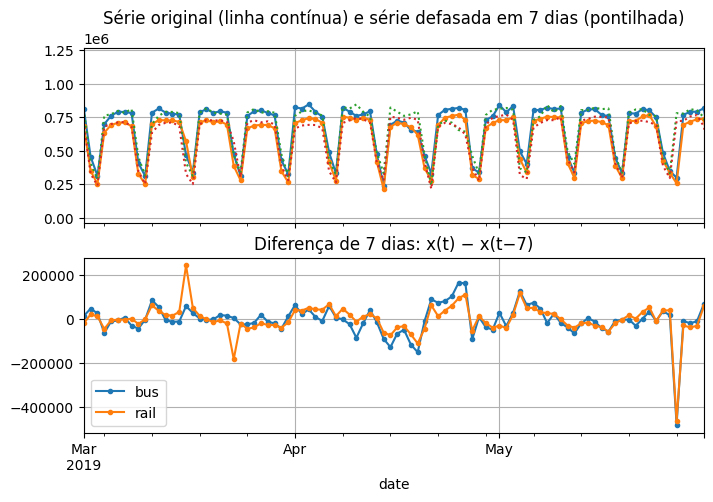

In [ ]:
# diferença de 7 dias
diff_7 = df[["bus", "rail"]].diff(7)["2019-03":"2019-05"]

# cria os subplots
fig, axs = plt.subplots(
    2,
    1,
    figsize=(8, 5),
    sharex=True
)

# série temporal original (t)
df.plot(ax=axs[0], legend=False, marker=".")

# série temporal defasada em 7 dias (t−7)
df.shift(7).plot(ax=axs[0], grid=True, legend=False, linestyle=":")

# série temporal da diferença de 7 dias
diff_7.plot(ax=axs[1], grid=True, marker=".")

axs[0].set_title("Série original (linha contínua) e série defasada em 7 dias (pontilhada)")
axs[1].set_title("Diferença de 7 dias: x(t) − x(t−7)")


plt.show()


Linha pontilhada: valores observados sete dias antes, deslocados para o tempo 𝑡
t, correspondendo ao valor que teria sido utilizado como previsão caso uma estratégia ingênua baseada na repetição semanal fosse adotada.

A previsão apresentada é hipotética e tem como objetivo avaliar a adequação dessa estratégia simples, na qual o valor observado em t−7 é utilizado como previsão para o tempo t.

Observa-se que as diferenças oscilam em torno de zero, indicando a presença de um padrão semanal dominante, caracterizado por uma sazonalidade semanal forte na série temporal.

Mostra o tipo de dia (day_type) para cada data no intervalo especificado:

In [ ]:
list(df.loc["2019-05-25":"2019-05-27"]["day_type"])
['A', 'U', 'U']

['A', 'U', 'U']

Final de Maio apresntou diferenças muito bruscas, trazendo a possibilidade de ser um fim de semana ou feriado, o que pode ser confirmado pelo comando acima.

- A → sábado
- U → domingo ou feriado
- U → domingo ou feriado

Erro absoluto médio (MAE) da previsão ingênua semanal no período de março a maio de 2019.

In [ ]:
diff_7.abs().mean()

,0
bus,43915.608696
rail,42143.271739


### Erro percentual absoluto médio (MAPE)

Para avaliar se os valores do MAE são bons ou ruins, os erros de previsão podem ser colocados em perspectiva ao dividi-los pelos valores reais (variáveis-alvo).

In [ ]:
targets = df[["bus", "rail"]]["2019-03":"2019-05"]
(diff_7 / targets).abs().mean()

,0
bus,0.082938
rail,0.089948


Analise dos dados de 2001 a 2019 para investigar a presença de sazonalidade anual e tendências de longo prazo. Para isso, a série diária foi reamostrada em frequência mensal e foi calculada uma média móvel de 12 meses, permitindo a visualização de padrões recorrentes ao longo dos anos.

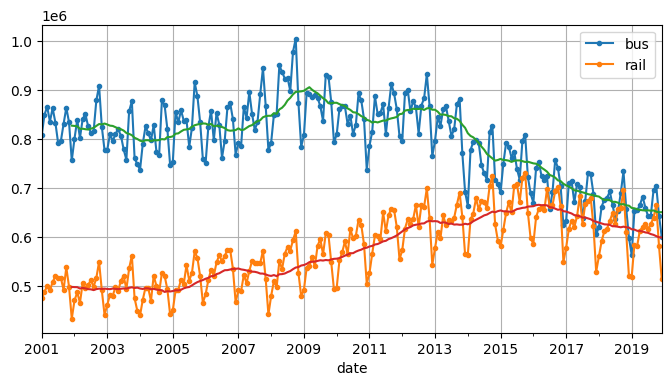

In [ ]:
period = slice("2001", "2019")

df_monthly = df.select_dtypes(include="number").resample('ME').mean()

rolling_average_12_months = df_monthly.loc[period].rolling(window=12).mean()

fig, ax = plt.subplots(figsize=(8, 4))
df_monthly[period].plot(ax=ax, marker=".")
rolling_average_12_months.plot(ax=ax, grid=True, legend=False)
plt.show()

Diferenciação sazonal anual (12 meses)

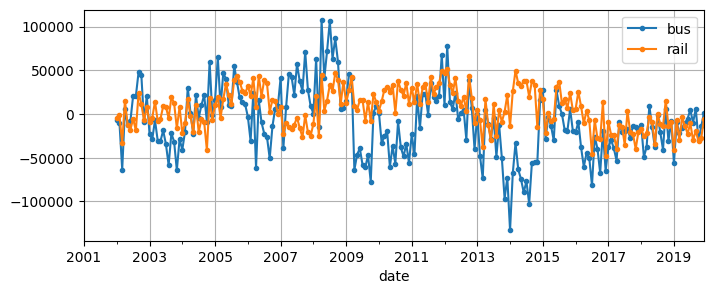

In [ ]:
df_monthly.diff(12)[period].plot(grid=True, marker=".", figsize=(8, 3))
plt.show()